# Transfer learning experiments

This notebook includes:
1) Implement a transfer learning from ImageNet > 13 diseases > 1 disease. 
2) Compared performance against ImageNet > 1 disease and ImageNet > MURA > 1 disease 

Results for disease corresponding to index 10.

## Imports & global variables

We choose `idx=10` because from previous experiments we have detected a strong signal and a sufficient amount of positive cases. 

In [27]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot, resize
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder, validate_binary



seed = 42
r_pix = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=r_pix)]
PRETRAINED = True
NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = '14diseases'


BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
# SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/chexPert-model'
IMG_FOLDER = PATH/'ChesXPert-250'

# Pre-process images

In [2]:
# ! mkdir $PATH/ChesXPert-250
# ! mkdir $BASE_PATH/'output/real_data_experiments/multilabel/chexPert-model'

In [141]:
! ls ../../data/CheXpert-v1.0-small

train  train.csv  valid  valid.csv


In [262]:
train_df = pd.read_csv(PATH/"CheXpert-v1.0-small/train.csv")
valid_df = pd.read_csv(PATH/"CheXpert-v1.0-small/valid.csv")

In [263]:
train_df.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

We are interested in similar chest x-ray images to the down-stream task. We filter the images to only use the frontal chest x-rays. 

In [264]:
train_df = train_df[train_df['Frontal/Lateral']=="Frontal"]
valid_df = valid_df[valid_df['Frontal/Lateral']=="Frontal"]

Target in the paper are `Atelectasis`, `Cardiomegaly`, `Consolidation`, `Edema` and `Pleural Effusion`.

In [265]:
target_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
keep_columns = ['Path'] + target_columns

In [266]:
train_df = train_df[keep_columns]
valid_df = valid_df[keep_columns]

We will replace uncertain labels according to the best result between those two approaches in Table 3 of [CheXpert: A Large Chest Radiograph Dataset
with Uncertainty Labels and Expert Comparison](https://arxiv.org/pdf/1901.07031.pdf). Following the approach of [Simon](https://github.com/simongrest/chexpert-entries/blob/master/replicating_chexpert.ipynb) for simplicity.

In [267]:
one_na_features = ['Atelectasis', 'Edema']
zero_na_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

In [268]:
def na_imputation(df, one_features=one_na_features, zero_features=zero_na_features):
    
    for feature in target_columns:
        df[feature][df[feature].isna()] = 1 if feature in one_features else 0
        df[feature] = df[feature].astype(int)
    
    return df

train_df = na_imputation(train_df)
valid_df = na_imputation(valid_df)

In [269]:
train_df.isna().sum()

Path                0
Atelectasis         0
Cardiomegaly        0
Consolidation       0
Edema               0
Pleural Effusion    0
dtype: int64

In [270]:
len(train_df), len(valid_df), len(train_df) + len(valid_df)

(191027, 202, 191229)

Increase validation dataset.

In [271]:
train_idx = np.random.choice(train_df.index, int(len(train_df)*.9), replace=False)

df_aux = train_df[np.logical_not(train_df.index.isin(train_idx))]
train_df = train_df.loc[train_idx,:]
valid_df = pd.concat([valid_df, df_aux])

In [272]:
len(train_df), len(valid_df), len(train_df) + len(valid_df)

(171924, 19305, 191229)

In MURA we have:
* 36,808 training examples 
* 3,197 validation examples

For a fair comparison let's down-sample this one.

In [273]:
# train_df = train_df.sample(n=36808, replace=False)
# valid_df = valid_df.sample(n=3197, replace=False)

In [274]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

# Resize images

Get aspect ratio:

In [196]:
from collections import Counter

In [198]:
c = Counter()

In [203]:
def most_common_aspect_ratio(df):
    c = []
    for p in tqdm_notebook(df.Path):
        path = ORIG_PATH/p
        x = cv2.imread(str(path))#.astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) #/ 255
        h,w, _ = x.shape
        c.append(round(h/w, 1))
    c = Counter(c)
    return c.most_common(1)

# Run once
# most_common = most_common_aspect_ratio(train_df)
# most_common

A Jupyter Widget

[(0.8, 144030)]

We obtain a aspect ratio of $\frac{h}{w}=0.8$.

In [211]:
ASPECT_RATIO=.8

In [275]:
def resize_all(df, dir_from, dir_to):
    for idx in tqdm_notebook(range(len(df))):
        path = dir_from/df.Path[idx]
        x = cv2.imread(str(path))#.astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) #/ 255
#         'CheXpert-v1.0-small/train/patient04427/study28/view2_frontal.jpg' -> 'train_patient04427_study28_view2_frontal.jpg'
        new_p = '_'.join(df.Path[idx].split('/')[1:])
        x = resize(x, (250, int(250*.8)))
        df['Path'][idx] = new_p
        cv2.imwrite(str(dir_to/new_p), x)
    return df

In [276]:
ORIG_PATH = PATH
DEST_PATH = PATH/'ChesXPert-250'

In [ ]:
train_df = resize_all(train_df, ORIG_PATH, DEST_PATH)
valid_df = resize_all(valid_df, ORIG_PATH, DEST_PATH)

A Jupyter Widget

In [281]:
# train_df.to_csv('train_df_chexpert_resized.csv')
# valid_df.to_csv('valid_df_chexpert_resized.csv')

In [283]:
path = DEST_PATH/train_df.Path[0]
x = cv2.imread(str(path))#.astype(np.float32)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

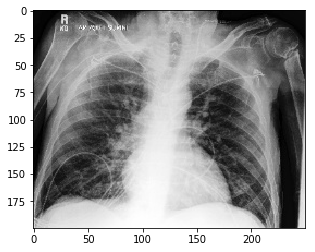

In [284]:
plt.imshow(x)

# Algorithm itself

In [28]:
train_df = pd.read_csv('train_df_chexpert_resized.csv')
valid_df = pd.read_csv('valid_df_chexpert_resized.csv')

# Dataset and Dataloader

In [29]:
class CheXPertDataSet(Dataset):
    """
    Basic Images DataSet

    Args:
        dataframe with data: image_file, label
    """

    def __init__(self, df, image_path, idx):
        self.image_files = df["Path"].values
        # self.labels = df["Label"].values
        self.lables = df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']].values
        self.lables[self.lables==-1] = 0
        self.image_path = image_path

    def __getitem__(self, index):
        path = self.image_path / self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        y = self.lables[index]
        return x, y

    def __len__(self):
        return len(self.image_files)
    
class DataBatches:
    '''
    Creates a dataloader using the specificed data frame with the dataset corresponding to "data".
    '''

    def __init__(self, df, idx, transforms, shuffle, img_folder_path, batch_size=16, num_workers=8,
                 drop_last=False, r_pix=8, normalize=True, seed=42):

        self.dataset = Transform(CheXPertDataSet(df, image_path=img_folder_path, idx=idx),
                                 transforms=transforms, normalize=normalize, seed=seed, r_pix=r_pix)
        self.dataloader = DataLoader(
            self.dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
            shuffle=shuffle, drop_last=drop_last
        )
       

    def __iter__(self): return ((x.cuda().float(), y.cuda().float()) for (x, y) in self.dataloader)

    def __len__(self): return len(self.dataloader)

    def set_random_choices(self):
        if hasattr(self.dataset, "set_random_choices"): self.dataset.set_random_choices()


In [30]:
train_dl = DataBatches(df=train_df, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

In [24]:
# train_dl.set_random_choices()
# x,y = next(iter(train_dl))
# x.shape, y.shape

# Lr finder

A Jupyter Widget

A Jupyter Widget

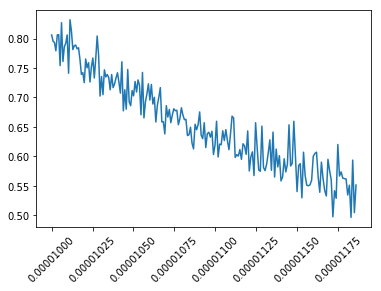

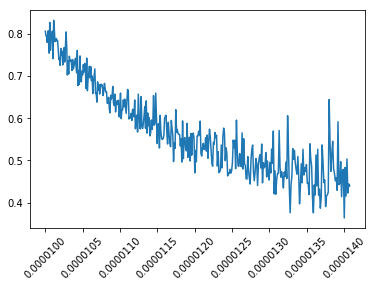

In [25]:
m = DenseNet121(out_size=5, pretrained=PRETRAINED, freeze=False).cuda()
lrs, losses = lr_finder(m, n_epochs=1, train_dl=train_dl, min_lr=.1e-4, early_stopping=500)

In [13]:
def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

In [ ]:
# transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]

# train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
#                        shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet121(5, pretrained=PRETRAINED, freeze=FREEZE).cuda()
save_path = '/data/miguel/practicum/latest_models/chexpert_densenet121.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.4187 -  val loss 0.4109 AUC 0.6473


A Jupyter Widget

Ep. 2 - train loss 0.3729 -  val loss 0.3796 AUC 0.7364


A Jupyter Widget

Ep. 3 - train loss 0.3649 -  val loss 0.3690 AUC 0.7448


A Jupyter Widget

Ep. 4 - train loss 0.3569 -  val loss 0.3654 AUC 0.7450


A Jupyter Widget

Ep. 5 - train loss 0.3512 -  val loss 0.3625 AUC 0.7492


A Jupyter Widget

## Script

In [37]:
%%writefile train_chexpert.py

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, validate_multilabel, TTA_multilabel

seed = 42
r_pix = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=r_pix)]
PRETRAINED = NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = '14diseases'

BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
# SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/chexPert-model'
IMG_FOLDER = PATH/'ChesXPert-250'

##### < --- Data set / loader ---> #####
class CheXPertDataSet(Dataset):
    """
    Basic Images DataSet

    Args:
        dataframe with data: image_file, label
    """

    def __init__(self, df, image_path, idx):
        self.image_files = df["Path"].values
        # self.labels = df["Label"].values
        self.lables = df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']].values
        self.image_path = image_path

    def __getitem__(self, index):
        path = self.image_path / self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        y = self.lables[index]
        return x, y

    def __len__(self):
        return len(self.image_files)
    
class DataBatches:
    '''
    Creates a dataloader using the specificed data frame with the dataset corresponding to "data".
    '''

    def __init__(self, df, idx, transforms, shuffle, img_folder_path, batch_size=16, num_workers=8,
                 drop_last=False, r_pix=8, normalize=True, seed=42):

        self.dataset = Transform(CheXPertDataSet(df, image_path=img_folder_path, idx=idx),
                                 transforms=transforms, normalize=normalize, seed=seed, r_pix=r_pix)
        self.dataloader = DataLoader(
            self.dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
            shuffle=shuffle, drop_last=drop_last
        )
       

    def __iter__(self): return ((x.cuda().float(), y.cuda().float()) for (x, y) in self.dataloader)

    def __len__(self): return len(self.dataloader)

    def set_random_choices(self):
        if hasattr(self.dataset, "set_random_choices"): self.dataset.set_random_choices()

            
##### < --- Training ---> #####

def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

            
train_df = pd.read_csv('train_df_chexpert_resized.csv')
valid_df = pd.read_csv('valid_df_chexpert_resized.csv')

train_dl = DataBatches(df=train_df, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

model = DenseNet121(5, pretrained=PRETRAINED, freeze=FREEZE).cuda()

model_p = '/data/miguel/practicum/latest_models/chexpert_densenet121.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)


Overwriting train_13_labels.py


# Downstream task - 1 label (small data)

Balance training and testing.

In [111]:
# To balance validation and testing
def decode_labels(df_col):
    return np.array(list(map(np.array, df_col.str.split(' ')))).astype(int)

def subset_df(df, amt, idx=IDX):
    
    lbls = decode_labels(df.Label)
    
    pos_idxs = lbls[:,idx].astype(bool)

    neg = df[~pos_idxs].sample(n=amt//2, replace=False)
    pos = df[pos_idxs].sample(n=amt//2, replace=False)

    return pd.concat([neg, pos]).reset_index(drop=True)

In [112]:
class ChestXray1DataSet(Dataset):
    """
    Basic Images DataSet

    Args:
        dataframe with data: image_file, label
    """

    def __init__(self, df, image_path, idx):
        self.image_files = df["ImageIndex"].values
        self.lables = np.array([obs.split(" ")[idx]
                                for obs in df.Label]).astype(np.float32)
        self.image_path = image_path

    def __getitem__(self, index):
        path = self.image_path / self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        y = self.lables[index]
        return x, y

    def __len__(self):
        return len(self.image_files)
    
class DataBatches:
    '''
    Creates a dataloader using the specificed data frame with the dataset corresponding to "data".
    '''

    def __init__(self, df, idx, transforms, shuffle, img_folder_path, batch_size=16, num_workers=8,
                 drop_last=False, r_pix=8, normalize=True, seed=42):

        self.dataset = Transform(ChestXray1DataSet(df, image_path=img_folder_path, idx=idx),
                                 transforms=transforms, normalize=normalize, seed=seed, r_pix=r_pix)
        self.dataloader = DataLoader(
            self.dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
            shuffle=shuffle, drop_last=drop_last
        )
       

    def __iter__(self): return ((x.cuda().float(), y.cuda().float()) for (x, y) in self.dataloader)

    def __len__(self): return len(self.dataloader)

    def set_random_choices(self):
        if hasattr(self.dataset, "set_random_choices"): self.dataset.set_random_choices()

# test
# dl = DataBatches(df=train_df, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
#                  img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
#                  r_pix=r_pix, normalize=NORMALIZE, seed=seed)
# dl.set_random_choices()
# next(iter(dl))

In [113]:
train_df = pd.read_csv('train_df_small.csv')
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

val_amt = 2*decode_labels(valid_df.Label)[:,IDX].sum()
test_amt = 2*decode_labels(test_df.Label)[:,IDX].sum()

valid_df_balanced = subset_df(valid_df, val_amt, idx=IDX)
test_df_balanced = subset_df(test_df, test_amt, idx=IDX)

amt = 2000
train_df_balanced = subset_df(train_df, amt, idx)

In [114]:
train_dl = DataBatches(df=train_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df_balanced, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

test_dl = DataBatches(df=test_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                      r_pix=r_pix, normalize=NORMALIZE, seed=seed)

A Jupyter Widget

A Jupyter Widget

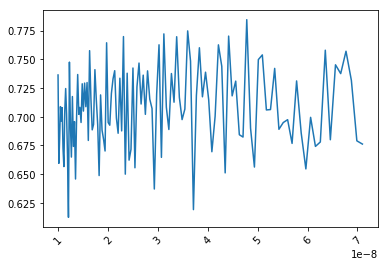

A Jupyter Widget

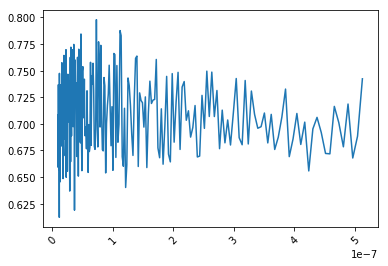

A Jupyter Widget

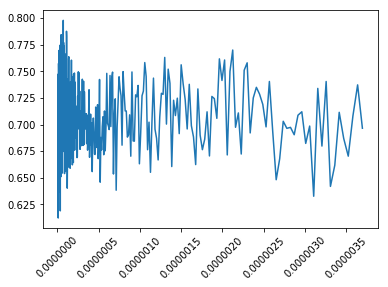

A Jupyter Widget

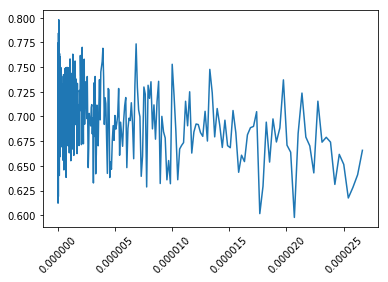

A Jupyter Widget

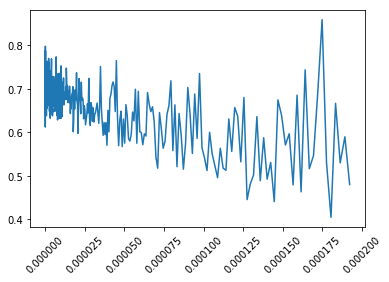

A Jupyter Widget

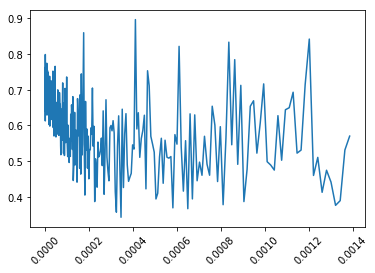

A Jupyter Widget

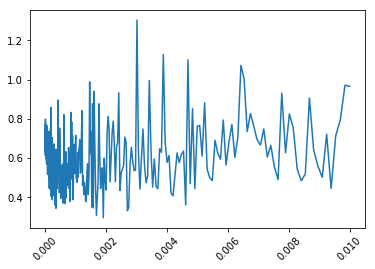

In [120]:
m = DenseNet121(out_size=1, pretrained=PRETRAINED, freeze=False).cuda()
lrs, losses = lr_finder(m, n_epochs=7, train_dl=train_dl, min_lr=1e-8, max_lr=1e-2,early_stopping=2_000, plot_every=125)

In [126]:
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out.squeeze(), target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Comparison on the Downstream task

\# Samples = 2,000

In [150]:
from train_functions import TTA_binary

In [151]:
train_df = pd.read_csv('train_df_small.csv')
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

val_amt = 2*decode_labels(valid_df.Label)[:,IDX].sum()
test_amt = 2*decode_labels(test_df.Label)[:,IDX].sum()

valid_df_balanced = subset_df(valid_df, val_amt, idx=IDX)
test_df_balanced = subset_df(test_df, test_amt, idx=IDX)

amt = 2000
train_df_balanced = subset_df(train_df, amt, idx)

In [152]:
train_dl = DataBatches(df=train_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df_balanced, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

test_dl = DataBatches(df=test_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                      r_pix=r_pix, normalize=NORMALIZE, seed=seed)

## ImageNet

In [ ]:
pretrained = True
model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()
model_p = 'best_imagenet.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('Testing with TTA ....')
load_model(model, model_p)
TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.7056 -  val loss 0.6927 AUC 0.5692


A Jupyter Widget

Ep. 2 - train loss 0.5883 -  val loss 0.5503 AUC 0.8024


A Jupyter Widget

Ep. 3 - train loss 0.5027 -  val loss 0.4409 AUC 0.8733


A Jupyter Widget

Ep. 4 - train loss 0.4440 -  val loss 0.5262 AUC 0.8317


A Jupyter Widget

Ep. 5 - train loss 0.4056 -  val loss 0.4472 AUC 0.8929


A Jupyter Widget

Ep. 6 - train loss 0.3121 -  val loss 0.4553 AUC 0.8757


A Jupyter Widget

Ep. 7 - train loss 0.2704 -  val loss 0.5285 AUC 0.8557


A Jupyter Widget

Ep. 8 - train loss 0.1920 -  val loss 0.5180 AUC 0.8769


A Jupyter Widget

Ep. 9 - train loss 0.1140 -  val loss 0.5434 AUC 0.8764


A Jupyter Widget

Ep. 10 - train loss 0.0928 -  val loss 0.5355 AUC 0.8815
Testing with TTA ....
TTA loss 0.5338  auc 0.8364  accuracy 0.7402


(0.5337812904905859, 0.8364088531443127, 0.7401646843549863)

## MURA

In [161]:
pretrained = 'MURA'

model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
model_p = 'best_MURA.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('Testing with TTA ....')
load_model(model, model_p)
TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.6922 -  val loss 0.6573 AUC 0.6630


A Jupyter Widget

Ep. 2 - train loss 0.5742 -  val loss 0.5328 AUC 0.8551


A Jupyter Widget

Ep. 3 - train loss 0.4859 -  val loss 0.4945 AUC 0.8417


A Jupyter Widget

Ep. 4 - train loss 0.4506 -  val loss 0.4370 AUC 0.8845


A Jupyter Widget

Ep. 5 - train loss 0.3831 -  val loss 0.4540 AUC 0.8796


A Jupyter Widget

Ep. 6 - train loss 0.3053 -  val loss 0.4948 AUC 0.8856


A Jupyter Widget

Ep. 7 - train loss 0.2493 -  val loss 0.5398 AUC 0.8710


A Jupyter Widget

Ep. 8 - train loss 0.1669 -  val loss 0.5882 AUC 0.8581


A Jupyter Widget

Ep. 9 - train loss 0.1051 -  val loss 0.5985 AUC 0.8704


A Jupyter Widget

Ep. 10 - train loss 0.0988 -  val loss 0.5973 AUC 0.8717
Testing with TTA ....
TTA loss 0.4886  auc 0.8702  accuracy 0.7795


(0.4886257546423012, 0.8701903236850321, 0.7795059469350412)

## 13 diseases

In [162]:
pretrained = '13diseases'
model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
model_p = 'best_13diseases.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('Testing with TTA ....')
load_model(model, model_p)
TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.6857 -  val loss 0.6332 AUC 0.7483


A Jupyter Widget

Ep. 2 - train loss 0.5503 -  val loss 0.4490 AUC 0.8720


A Jupyter Widget

Ep. 3 - train loss 0.4400 -  val loss 0.4163 AUC 0.8896


A Jupyter Widget

Ep. 4 - train loss 0.3756 -  val loss 0.4397 AUC 0.8864


A Jupyter Widget

Ep. 5 - train loss 0.3289 -  val loss 0.3988 AUC 0.9034


A Jupyter Widget

Ep. 6 - train loss 0.2489 -  val loss 0.4012 AUC 0.9045


A Jupyter Widget

Ep. 7 - train loss 0.1899 -  val loss 0.4628 AUC 0.8911


A Jupyter Widget

Ep. 8 - train loss 0.1460 -  val loss 0.5002 AUC 0.8940


A Jupyter Widget

Ep. 9 - train loss 0.1035 -  val loss 0.4874 AUC 0.8942


A Jupyter Widget

Ep. 10 - train loss 0.0996 -  val loss 0.4878 AUC 0.8982
Testing with TTA ....
TTA loss 0.4865  auc 0.8898  accuracy 0.7896


(0.48647970565120124, 0.8898170090126891, 0.7895699908508692)

## Script

In [196]:
%%writefile train_test_1_label_3transfer_learning.py

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder, validate_binary, TTA_binary
import json

SEED = 42
R_PIX = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=R_PIX)]
NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
# n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]
n_samples = [6, 12, 24, 36, 48]
print(n_samples)
BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
IMG_FOLDER = PATH/'ChestXRay-250'

# To balance validation and testing
def decode_labels(df_col):
    return np.array(list(map(np.array, df_col.str.split(' ')))).astype(int)

def subset_df(df, amt, idx=IDX):
    
    lbls = decode_labels(df.Label)
    
    pos_idxs = lbls[:,idx].astype(bool)

    neg = df[~pos_idxs].sample(n=amt//2, replace=False)
    pos = df[pos_idxs].sample(n=amt//2, replace=False)

    return pd.concat([neg, pos]).reset_index(drop=True)

class ChestXray1DataSet(Dataset):
    """
    Basic Images DataSet

    Args:
        dataframe with data: image_file, label
    """

    def __init__(self, df, image_path, idx):
        self.image_files = df["ImageIndex"].values
        self.lables = np.array([obs.split(" ")[idx]
                                for obs in df.Label]).astype(np.float32)
        self.image_path = image_path

    def __getitem__(self, index):
        path = self.image_path / self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        y = self.lables[index]
        return x, y

    def __len__(self):
        return len(self.image_files)
    
class DataBatches:
    '''
    Creates a dataloader using the specificed data frame with the dataset corresponding to "data".
    '''

    def __init__(self, df, idx, transforms, shuffle, img_folder_path, batch_size=16, num_workers=8,
                 drop_last=False, r_pix=8, normalize=True, seed=42):

        self.dataset = Transform(ChestXray1DataSet(df, image_path=img_folder_path, idx=idx),
                                 transforms=transforms, normalize=normalize, seed=seed, r_pix=r_pix)
        self.dataloader = DataLoader(
            self.dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
            shuffle=shuffle, drop_last=drop_last
        )
       

    def __iter__(self): return ((x.cuda().float(), y.cuda().float()) for (x, y) in self.dataloader)

    def __len__(self): return len(self.dataloader)

    def set_random_choices(self):
        if hasattr(self.dataset, "set_random_choices"): self.dataset.set_random_choices()
            
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out.squeeze(), target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss
            
            
train_df = pd.read_csv('train_df_small.csv')
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

val_amt = 2*decode_labels(valid_df.Label)[:,IDX].sum()
test_amt = 2*decode_labels(test_df.Label)[:,IDX].sum()

valid_df_balanced = subset_df(valid_df, val_amt, idx=IDX)
test_df_balanced = subset_df(test_df, test_amt, idx=IDX)

valid_dl = DataBatches(df=valid_df_balanced, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)

test_dl = DataBatches(df=test_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                      r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)

no_pretrained = {'loss': [],
           'auc': [],
           'accuracy': []}

imagenet = {'loss': [],
           'auc': [],
           'accuracy': []}

MURA = {'loss': [],
           'auc': [],
           'accuracy': []}

diseases13 = {'loss': [],
           'auc': [],
           'accuracy': []}

for N in n_samples:
    
    train_df_balanced = subset_df(train_df, N, idx=IDX)

    train_dl = DataBatches(df=train_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                           r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)

    valid_dl = DataBatches(df=valid_df_balanced, idx=IDX, transforms=None, shuffle=False,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE,
                           r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)

    test_dl = DataBatches(df=test_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False,
                          img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE,
                          r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)
    
    print('ImageNet...')
    pretrained = True
    model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
    model_p = f'models/best_{N}_imagenet.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
          unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None)
    
    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    imagenet['loss'].append(loss)
    imagenet['auc'].append(auc)
    imagenet['accuracy'].append(accuracy)
    
    print('MURA...')
    pretrained = 'MURA'
    model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
    model_p = f'models/best_{N}_MURA.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
          unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None)

    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    MURA['loss'].append(loss)
    MURA['auc'].append(auc)
    MURA['accuracy'].append(accuracy)
    
    print('13 diseases...')
    pretrained = '13diseases'
    model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
    model_p = f'models/best_{N}_13diseases.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
          unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None)

    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    diseases13['loss'].append(loss)
    diseases13['auc'].append(auc)
    diseases13['accuracy'].append(accuracy)
    
    train_dl = DataBatches(df=train_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE,
                           r_pix=R_PIX, normalize=False, seed=SEED)

    valid_dl = DataBatches(df=valid_df_balanced, idx=IDX, transforms=None, shuffle=False,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE,
                           r_pix=R_PIX, normalize=False, seed=SEED)

    test_dl = DataBatches(df=test_df_balanced, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False,
                          img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE,
                          r_pix=R_PIX, normalize=False, seed=SEED)

    print('No pretrained...')
    pretrained = True
    model = DenseNet121(1, pretrained=False, freeze=False).cuda()
    model_p = f'models/best_{N}_no_pretrained.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p,
          unfreeze_during_loop=None)

    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    no_pretrained['loss'].append(loss)
    no_pretrained['auc'].append(auc)
    no_pretrained['accuracy'].append(accuracy)

imagenet = json.dumps(imagenet)
# with open('data_plots/imagenet.json', 'w') as f:
with open('data_plots/imagenet_small.json', 'w') as f:
    f.write(imagenet)

MURA = json.dumps(MURA)
# with open('data_plots/MURA.json', 'w') as f:
with open('data_plots/MURA_small.json', 'w') as f:
    f.write(MURA)
    
diseases13 = json.dumps(diseases13)
# with open('data_plots/13diseases.json', 'w') as f:
with open('data_plots/13diseases_small.json', 'w') as f:
    f.write(diseases13)

no_pretrained = json.dumps(no_pretrained)
# with open('data_plots/13diseases.json', 'w') as f:
with open('data_plots/no_pretrained_small.json', 'w') as f:
    f.write(no_pretrained)


Overwriting train_test_1_label_3transfer_learning.py


# Results spectrum 50-2000

In [240]:
import json

In [241]:
! ls ./data_plots

13diseases.json        MURA_small.json	    no_pretrained.json
13diseases_small.json  imagenet.json	    no_pretrained_small.json
MURA.json	       imagenet_small.json


In [242]:
x = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]
with open('./data_plots/no_pretrained.json') as json_f:
    no_pretrained = json.load(json_f)
with open('./data_plots/imagenet.json') as json_f:
    imagenet = json.load(json_f)
with open('./data_plots/MURA.json') as json_f:
    MURA = json.load(json_f)
with open('./data_plots/13diseases.json') as json_f:
    diseases13 = json.load(json_f)

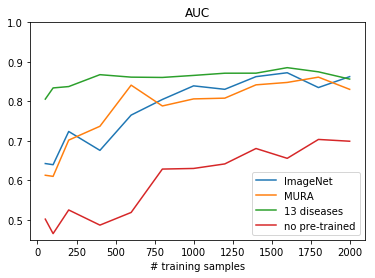

In [243]:
plt.plot(x,imagenet['auc'], label="ImageNet")
plt.plot(x,MURA['auc'], label="MURA")
plt.plot(x,diseases13['auc'], label="13 diseases")
plt.plot(x,no_pretrained['auc'], label="no pre-trained")
plt.legend()
plt.ylim(.45,1)
plt.title('AUC')
plt.xlabel("# training samples")
plt.show()

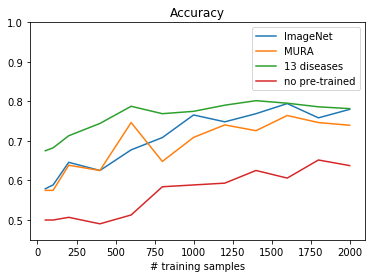

In [244]:
plt.plot(x,imagenet['accuracy'], label="ImageNet")
plt.plot(x,MURA['accuracy'], label="MURA")
plt.plot(x,diseases13['accuracy'], label="13 diseases")
plt.plot(x,no_pretrained['accuracy'], label="no pre-trained")
plt.legend()
plt.ylim(.45,1)
plt.title('Accuracy')
plt.xlabel("# training samples")
plt.show()

# Small 5-50

In [245]:
! ls ./data_plots/

13diseases.json        MURA_small.json	    no_pretrained.json
13diseases_small.json  imagenet.json	    no_pretrained_small.json
MURA.json	       imagenet_small.json


In [246]:
x = [8,  16, 24, 32, 40, 48]
with open('./data_plots/no_pretrained_small.json') as json_f:
    no_pretrained = json.load(json_f)
with open('./data_plots/imagenet_small.json') as json_f:
    imagenet = json.load(json_f)
with open('./data_plots/MURA_small.json') as json_f:
    MURA = json.load(json_f)
with open('./data_plots/13diseases_small.json') as json_f:
    diseases13 = json.load(json_f)

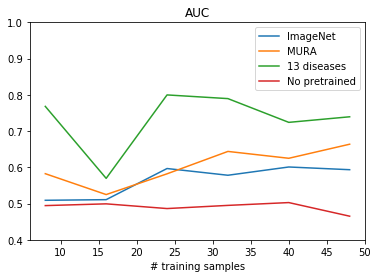

In [247]:
plt.plot(x,imagenet['auc'], label="ImageNet")
plt.plot(x,MURA['auc'], label="MURA")
plt.plot(x,diseases13['auc'], label="13 diseases")
plt.plot(x,no_pretrained['auc'], label="No pretrained")
plt.legend()
plt.ylim(.4,1)
plt.title('AUC')
plt.xlabel("# training samples")
plt.show()

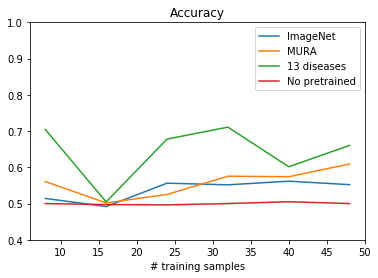

In [248]:
plt.plot(x,imagenet['accuracy'], label="ImageNet")
plt.plot(x,MURA['accuracy'], label="MURA")
plt.plot(x,diseases13['accuracy'], label="13 diseases")
plt.plot(x,no_pretrained['accuracy'], label="No pretrained")
plt.legend()
plt.ylim(.4,1)
plt.title('Accuracy')
plt.xlabel("# training samples")
plt.show()